<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/BraxMetaLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hebbian Meta-Learning with EvoJAX
This notebook reproduces [Meta-Learning through Hebbian Plasticity in
Random Networks](https://arxiv.org/abs/2007.02686) in EvoJAX.

This will not be an apples to apples reproduction of the results from the paper since the Ant environment is from a different library since we need to use a library that can be jitted by Jax. This means that the phyisics will be slightly different and the reward is also not the same. We reproduce the results showing the learned policy recovering from damaged weights.

In [ ]:
# @title Install Packages

from IPython.display import clear_output

!pip install git+https://github.com/google/evojax.git@main
!pip install git+https://github.com/google/brax.git@main

!pip install mediapy

clear_output()

In [ ]:
# @title Import Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from brax import envs
from brax import jumpy as jp
from brax.io import html

import jax
import jax.numpy as jnp
from jax import random

from evojax import SimManager
from evojax import ObsNormalizer
from evojax.algo import PGPE
from evojax.task.brax_task import BraxTask

import mediapy as media

import os
if 'COLAB_TPU_ADDR' in os.environ:
    from jax.tools import colab_tpu
    colab_tpu.setup_tpu()

print('jax.devices():')
jax.devices()

jax.devices():


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
# @title Set hyper-parameters
# @markdown PLEASE NOTE: `pop_size` and `num_tests` should be multiples of `jax.local_device_count()`.

n_devices = jax.local_device_count()

pop_size = 1024  # @param
num_tests = 128  # @param
assert pop_size % n_devices == 0
assert num_tests % n_devices == 0

max_iters = 300  # @param
center_lr = 0.01  # @param
init_std = 0.04  # @param
std_lr = 0.07  # @param

seed = 42  # @param

env_name = "ant"  # @param ['ant', 'humanoid', 'halfcheetah', 'fetch']

# Meta-learning Policy

In [ ]:
from typing import Sequence
from typing import Tuple
from flax import linen as nn
from flax.struct import dataclass
from evojax.policy.base import PolicyNetwork
from evojax.policy.base import PolicyState
from evojax.task.base import TaskState

from evojax.util import get_params_format_fn

@dataclass
class MetaMLPPolicyState(PolicyState):
  # Flag to indicate if this is the first step in the policy
  first: jnp.ndarray
  # Since we update the wights using the hebbian rules each time the policy
  # takes a step, these 'fast weights' need to be stored in the policy state.
  fast_Ws: Sequence[jnp.ndarray]


class MetaMLPPolicy(PolicyNetwork):
  """A meta-learning policy. Uses the same algorithm as 
  Meta-Learning through Hebbian Plasticity in Random Networks
  [Najarro, Elias, and Sebastian Risi.]
  
  NOTE: No bias params are added to match the the paper.
  """

  def __init__(self, hidden_dims: Sequence[int]):
    self._hidden_dims = hidden_dims
    # Initial values of the weights, used when state.first == True.
    params = []
    for i in range(len(hidden_dims)-1):
      params.append(jnp.zeros((hidden_dims[i], hidden_dims[i+1])))

    # Add hebbian learning parameters for each weight matrix.
    hebbian = []
    for param in params:
      # Create 5 copies of the params for the A, B, C, D and learning rate
      # meta learning parameters.
      hebbian.append([param] * 5)

    params.append(hebbian)

    self.num_params, format_params_fn = get_params_format_fn(params)
    self._format_params_fn = jax.vmap(format_params_fn)

    
    def apply(params, x, p_states):
      *params, hebbian = params

      # Fetch the weights, if it's the first step get the learnt initial
      # weights, otherwise fetch the fast weights from the state.
      fast_params = []
      for i, w in enumerate(params):
        fast_params.append(jax.lax.cond(
            p_states.first,
            lambda: w,
            lambda: p_states.fast_Ws[i]
            )
        )
      
      # Forward computation of a normal neural network, record the activations
      # for the meta-learning step next.
      acts = [x]
      for w in fast_params[:-1]:
        x = nn.tanh(jnp.dot(x, w))
        acts.append(x)
      
      final_w = fast_params[-1]
      out = jnp.dot(x, final_w)
      acts.append(out)
      
      # Meta-learning
      new_weights = []
      for i, (fast_param, heb) in enumerate(zip(fast_params, hebbian)):
        lr, A, B, C, D = heb
        # This code makes use of broadcasting to compute the activation
        # interactions as shown.
        update = (
            # [m, 1] * [1, n] --> [m, n]
            (A * (acts[i][:, jnp.newaxis] * acts[i+1][jnp.newaxis, :])) +
            # [m, n] * [m, 1] --> [m, n]
            (B * acts[i][:, jnp.newaxis]) + 
            # [m, n] * [1, n] --> [m, n]
            (C * acts[i+1][jnp.newaxis, :]) + 
            D 
        )
        # Update the weights modulated by the learning rate
        new_w = fast_param + lr * update

        # Normalize the weights after updating, very important!
        # https://github.com/enajx/HebbianMetaLearning/blob/master/fitness_functions.py#L226
        new_w /= jnp.abs(new_w).max()
        new_weights.append(new_w)

      p_states = MetaMLPPolicyState(
          keys=p_states.keys, 
          first=False,  # Next step will not be the first step
          fast_Ws = new_weights
      )
      
      return out, p_states

    self._forward_fn = jax.vmap(apply)

  def get_actions(self,
                  t_states: TaskState,
                  params: jnp.ndarray,
                  p_states: PolicyState) -> Tuple[jnp.ndarray, PolicyState]:
    params = self._format_params_fn(params)
    return self._forward_fn(params, t_states.obs, p_states)

  def reset(self, states: TaskState) -> PolicyState:
    if len(states.obs.shape) == 2:
      dims = states.obs.shape[0]
    else:
      dims = 1
    
    # Here we seem to initialize the fast weights to zero but these are never
    # used. They are set here to ensure that the shapes are consistent.
    # The first time the policy is called this is set to the learned inital 
    # weights from the policy's paramteres.
    fast_W = []
    for i in range(len(self._hidden_dims)-1):
      fast_W.append(
          jnp.zeros((dims, self._hidden_dims[i], self._hidden_dims[i+1])))
    
    return MetaMLPPolicyState(
        keys=jax.random.split(jax.random.PRNGKey(42), dims),
        first=jnp.array([True] * dims),
        fast_Ws=fast_W,
    )

In [ ]:
train_task = BraxTask(env_name=env_name, test=False)
test_task = BraxTask(env_name=env_name, test=True)
    
# Use the same archatecture as the paper.
policy = MetaMLPPolicy(
    hidden_dims=[
        train_task.obs_shape[0],
        128,
        64,
        train_task.act_shape[0]]
)

In [ ]:
print('#params={}'.format(policy.num_params))

# We are using different solver here but OpenES can also be used like the paper.
solver = PGPE(
    pop_size=pop_size,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=center_lr,
    stdev_learning_rate=std_lr,
    init_stdev=init_std,
    seed=seed,
)

obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape)
sim_mgr = SimManager(
    n_repeats=1,
    test_n_repeats=1,
    pop_size=pop_size,
    n_evaluations=num_tests,
    policy_net=policy,
    train_vec_task=train_task,
    valid_vec_task=test_task,
    seed=seed,
    obs_normalizer=obs_normalizer,
)

#params=119040


In [ ]:
print('Start training Brax ({}) for {} iterations.'.format(env_name, max_iters))
start_time = time.perf_counter()
for train_iters in range(max_iters):
  
  # Training.
  params = solver.ask()
  scores, _ = sim_mgr.eval_params(params=params, test=False)
  solver.tell(fitness=scores)

  # Test periodically.
  if train_iters > 0 and train_iters % 10 == 0:
      best_params = solver.best_params
      scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
      score_best = scores.max()
      score_avg = np.mean(scores)
      score_std = np.std(scores)
      print('Iter={0}, #tests={1}, score.best={2:.2f}, score.avg={3:.2f}, score.std={4:.2f}'.format(
          train_iters, num_tests, score_best, score_avg, score_std))

# Final test.
best_params = solver.best_params
scores = np.array(sim_mgr.eval_params(params=best_params, test=True)[0])
score_best = scores.max()
score_avg = np.mean(scores)
score_std = np.std(scores)
print('Iter={0}, #tests={1}, score.best={2:.2f}, score.avg={3:.2f}, score.std={4:.2f}'.format(
    train_iters, num_tests, score_best, score_avg, score_std))
print('time cost: {}s'.format(time.perf_counter() - start_time))

Start training Brax (ant) for 300 iterations.


/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/dispatch.py:271: UserWarning: The jitted function <unnamed function> includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  f"The jitted function {name} includes a pmap. Using "
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)
/usr/loc

Iter=10, #tests=128, score.best=-103.77, score.avg=-458.22, score.std=980.94
Iter=20, #tests=128, score.best=-15.47, score.avg=-51.81, score.std=116.77
Iter=30, #tests=128, score.best=949.37, score.avg=892.34, score.std=20.82
Iter=40, #tests=128, score.best=1006.88, score.avg=995.11, score.std=3.78
Iter=50, #tests=128, score.best=1087.85, score.avg=1051.45, score.std=13.06
Iter=60, #tests=128, score.best=1437.95, score.avg=1382.67, score.std=25.49
Iter=70, #tests=128, score.best=1804.58, score.avg=1738.04, score.std=32.57
Iter=80, #tests=128, score.best=2081.95, score.avg=2034.40, score.std=20.53
Iter=90, #tests=128, score.best=2282.62, score.avg=2232.12, score.std=24.21
Iter=100, #tests=128, score.best=2456.80, score.avg=2395.29, score.std=24.76
Iter=110, #tests=128, score.best=2578.43, score.avg=2545.45, score.std=17.32
Iter=120, #tests=128, score.best=2699.68, score.avg=2668.50, score.std=14.11
Iter=130, #tests=128, score.best=2801.25, score.avg=2762.40, score.std=14.03
Iter=140, #t

In [ ]:
env_fn = envs.create_fn(
    env_name=env_name,
    legacy_spring=True
    )
env = env_fn()
state = env.reset(rng=jp.random_prngkey(seed=0))

In [ ]:
# @title Visualize the trained policy

task_reset_fn = jax.jit(env.reset)
policy_reset_fn = jax.jit(policy.reset)
step_fn = jax.jit(env.step)
act_fn = jax.jit(policy.get_actions)
obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

best_params = solver.best_params
obs_params = sim_mgr.obs_params

total_reward = 0
rollout = []
rewards = []
ws = []
rng = jax.random.PRNGKey(seed=42)
task_state = task_reset_fn(rng=rng)
policy_state = policy_reset_fn(task_state)

step = 0
while not task_state.done:
  rollout.append(task_state)
  task_state = task_state.replace(
    obs=obs_norm_fn(task_state.obs[None, :], obs_params))
  act, policy_state = act_fn(task_state, best_params[None, :], policy_state)
  # For 50 steps, completely zero out the weights to see if the policy can 
  # relearn weights that allow the ant to walk.
  if step > 500 and step < 550:
    policy_state.fast_Ws[1] *= 0
  task_state = step_fn(task_state, act[0])
  total_reward = total_reward + task_state.reward
  rewards.append(task_state.reward)
  # Record the weights every 10 steps for visualisations.
  if type(policy_state) is MetaMLPPolicyState and step % 10 == 0:
    ws.append(policy_state.fast_Ws)
  step += 1

print('rollout reward = {}'.format(total_reward))
HTML(html.render(env.sys, [s.qp for s in rollout]))

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


rollout reward = 3430.459228515625


In [ ]:
def show_weight_vid(w):
  def normalize(w):
    w += 1.0
    w /= 2.0
    return w
  w = jnp.concatenate(w)
  w = normalize(w)
  media.show_video(w,height=w.shape[1]*4,codec='gif',fps=5)

In [ ]:
wx, wh, wo = zip(*ws)

""

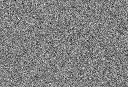

""

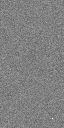

""


In [ ]:
show_weight_vid(wx)
show_weight_vid(wh)
show_weight_vid(wo)

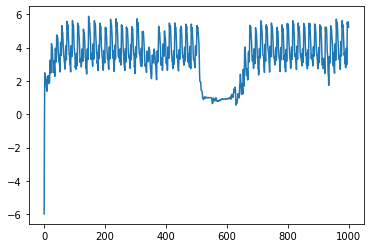

In [ ]:
# Note the dip at step 500 where the weights are damaged!
plt.plot(rewards);